In [1]:
import pandas as pd
df = pd.read_csv("data/splits/hand_labeled_2300.csv")

print("="*60)
print("SHAPE CLASS DISTRIBUTION")
print("="*60)
shape_counts = df['splshape_text'].value_counts().sort_values()
print(shape_counts)
print(f"Classes with only 1 sample: {(shape_counts == 1).sum()}")


print("\n" + "="*60)
print("COLOR CLASS DISTRIBUTION")
print("="*60)
color_counts = df['splcolor_text'].value_counts().sort_values()
print(color_counts)
print(f"Classes with only 1 sample: {(color_counts == 1).sum()}")

print("\n" + "="*60)
print("FORM DISTRIBUTION")
print("="*60)
form_counts = df['dosage_form'].value_counts().sort_values()
print(form_counts)
print(f"Classes with only 1 sample: {(form_counts == 1).sum()}")

df.head()

SHAPE CLASS DISTRIBUTION
splshape_text
DOUBLE CIRCLE            1
BULLET                   1
HEXAGON (6 SIDED)        1
PENTAGON (5 SIDED)       2
TEAR                     2
OCTAGON (8 SIDED)        4
FREEFORM                 4
RECTANGLE                8
SQUARE                   8
DIAMOND                 11
TRIANGLE                13
CAPSULE                545
OVAL                   638
ROUND                 1062
Name: count, dtype: int64
Classes with only 1 sample: 3

COLOR CLASS DISTRIBUTION
splcolor_text
BLACK           5
TURQUOISE       5
GRAY           28
PURPLE         41
RED            58
GREEN         111
BROWN         120
PINK          186
ORANGE        196
BLUE          222
YELLOW        278
WHITE        1050
Name: count, dtype: int64
Classes with only 1 sample: 0

FORM DISTRIBUTION
dosage_form
C61005      2
C42896      3
C42917      3
C42963      4
C42904      5
C42992     11
C42893     18
C42897     20
C42936     21
C42902     24
C42999     25
C42954     29
C42905     31
C4

,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,original_name,splimprint_clean
0,46329,PINK,OVAL,50458-920,Levaquin,C42931,50458-0920-50_38161C70,50458-0920-50_38161C70.jpg,LEVAQUIN_250
1,29212,WHITE,CAPSULE,0013-0132,Emcyt,C25158,000130132,000130132.jpg,PHARMACIA_AND_UPJOHN_EMCYT_140MG
2,41015,RED,OVAL,63044-631,HEMATOGEN,C25158,63044-0631-19_NLMIMAGE10_23409194,63044-0631-19_NLMIMAGE10_23409194.jpg,ZIKS_631
3,33754,ORANGE,CAPSULE,0008-0833,Effexor,C42916,00008-0833-21_3015981C,00008-0833-21_3015981C.jpg,W_EFFEXORXR_75
4,18889,BLUE,ROUND,0555-9018,Tri-Sprintec,C42998,00555-9018-58_NLMIMAGE10_2A369574,00555-9018-58_NLMIMAGE10_2A369574.jpg,B_986


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, auc
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [3]:
# Filter out classes with too few examples for stratified split
# Need at least 4 examples per class for 75/25 split (3 train, 1 test minimum)
shape_counts = df['splshape_text'].value_counts()
shapes_to_keep = shape_counts[shape_counts >= 4].index.tolist()

df_clean = df[df['splshape_text'].isin(shapes_to_keep)].copy()

print(f"Removed {len(shape_counts) - len(shapes_to_keep)} shape classes with < 4 examples")
print(f"Remaining shape classes: {sorted(shapes_to_keep)}\n")

# Check if image_path column exists, if not create it
if 'image_path' not in df_clean.columns:
    df_clean['image_path'] = df_clean['original_name'].apply(
        lambda x: os.path.join('data/pillbox_production_images_full_202008', x)
    )

df_clean = df_clean[df_clean['image_path'].apply(os.path.exists)]

# Initialize label encoders
le_shape = LabelEncoder()
le_color = LabelEncoder()
le_form = LabelEncoder()
df_clean['shape_label'] = le_shape.fit_transform(df_clean['splshape_text'])
df_clean['color_label'] = le_color.fit_transform(df_clean['splcolor_text'])
df_clean['form_label'] = le_form.fit_transform(df_clean['dosage_form'])

# Split into train and test (75/25 split) with stratification
train_df, test_df = train_test_split(
    df_clean, test_size=0.25, random_state=42, stratify=df_clean['shape_label']
)

print(f'Train: {len(train_df)}, Test: {len(test_df)}')
print(f'Shape classes: {len(le_shape.classes_)}, Color classes: {len(le_color.classes_)}, Form classes: {len(le_form.classes_)}')

Removed 5 shape classes with < 4 examples
Remaining shape classes: ['CAPSULE', 'DIAMOND', 'FREEFORM', 'OCTAGON (8 SIDED)', 'OVAL', 'RECTANGLE', 'ROUND', 'SQUARE', 'TRIANGLE']

Train: 1719, Test: 574
Shape classes: 9, Color classes: 12, Form classes: 19


In [4]:
class PillDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        shape_label = self.df.loc[idx, 'shape_label']
        color_label = self.df.loc[idx, 'color_label']
        form_label = self.df.loc[idx, 'form_label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, shape_label, color_label, form_label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PillDataset(train_df, train_transform)
test_dataset = PillDataset(test_df, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [5]:
class MultiTaskResNet(nn.Module):
    def __init__(self, num_shapes, num_colors, num_forms):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.shape_head = nn.Linear(in_features, num_shapes)
        self.color_head = nn.Linear(in_features, num_colors)
        self.form_head = nn.Linear(in_features, num_forms)
    
    def forward(self, x):
        features = self.backbone(x)
        shape_out = self.shape_head(features)
        color_out = self.color_head(features)
        form_out = self.form_head(features)
        return shape_out, color_out, form_out

model = MultiTaskResNet(len(le_shape.classes_), len(le_color.classes_), len(le_form.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

In [6]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    shape_correct = 0
    color_correct = 0
    form_correct = 0
    total = 0
    
    for images, shape_labels, color_labels, form_labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        shape_labels = shape_labels.to(device)
        color_labels = color_labels.to(device)
        form_labels = form_labels.to(device)
        
        optimizer.zero_grad()
        shape_out, color_out, form_out = model(images)
        
        shape_loss = criterion(shape_out, shape_labels)
        color_loss = criterion(color_out, color_labels)
        form_loss = criterion(form_out, form_labels)
        loss = shape_loss + color_loss + form_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, shape_pred = shape_out.max(1)
        _, color_pred = color_out.max(1)
        _, form_pred = form_out.max(1)
        total += shape_labels.size(0)
        shape_correct += shape_pred.eq(shape_labels).sum().item()
        color_correct += color_pred.eq(color_labels).sum().item()
        form_correct += form_pred.eq(form_labels).sum().item()
    
    return running_loss / total, shape_correct / total, color_correct / total, form_correct / total

In [7]:
def evaluate(model, loader):
    model.eval()
    shape_probs = []
    color_probs = []
    form_probs = []
    shape_labels = []
    color_labels = []
    form_labels = []
    shape_preds = []
    color_preds = []
    form_preds = []
    
    with torch.no_grad():
        for images, s_labels, c_labels, f_labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            shape_out, color_out, form_out = model(images)
            
            s_probs = torch.softmax(shape_out, dim=1)
            c_probs = torch.softmax(color_out, dim=1)
            f_probs = torch.softmax(form_out, dim=1)
            
            shape_probs.append(s_probs.cpu().numpy())
            color_probs.append(c_probs.cpu().numpy())
            form_probs.append(f_probs.cpu().numpy())
            shape_labels.append(s_labels.numpy())
            color_labels.append(c_labels.numpy())
            form_labels.append(f_labels.numpy())
            shape_preds.append(shape_out.cpu().numpy())
            color_preds.append(color_out.cpu().numpy())
            form_preds.append(form_out.cpu().numpy())
    
    return {
        'shape_probs': np.vstack(shape_probs),
        'color_probs': np.vstack(color_probs),
        'form_probs': np.vstack(form_probs),
        'shape_labels': np.concatenate(shape_labels),
        'color_labels': np.concatenate(color_labels),
        'form_labels': np.concatenate(form_labels),
        'shape_preds': np.vstack(shape_preds),
        'color_preds': np.vstack(color_preds),
        'form_preds': np.vstack(form_preds)
    }

In [8]:
def compute_metrics(probs, labels, preds, task_name):
    pred_classes = np.argmax(preds, axis=1)
    
    top1_acc = (pred_classes == labels).mean()
    
    top3_indices = np.argsort(preds, axis=1)[:, -3:]
    top3_acc = np.mean([labels[i] in top3_indices[i] for i in range(len(labels))])
    
    n_classes = probs.shape[1]
    pr_aucs = []
    ious = []
    aps = []
    
    for i in range(n_classes):
        binary_labels = (labels == i).astype(int)
        class_probs = probs[:, i]
        
        if binary_labels.sum() == 0:
            continue
        
        precision, recall, _ = precision_recall_curve(binary_labels, class_probs)
        pr_aucs.append(auc(recall, precision))
        
        pred_class = (pred_classes == i).astype(int)
        intersection = (binary_labels * pred_class).sum()
        union = (binary_labels + pred_class).clip(0, 1).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
        
        sorted_idx = np.argsort(class_probs)[::-1]
        tp = binary_labels[sorted_idx].cumsum()
        fp = (1 - binary_labels[sorted_idx]).cumsum()
        p = tp / (tp + fp + 1e-10)
        r = tp / binary_labels.sum()
        ap = np.sum((r[1:] - r[:-1]) * p[1:])
        aps.append(ap)
    
    return {
        f'{task_name}_top1_acc': top1_acc,
        f'{task_name}_top3_acc': top3_acc,
        f'{task_name}_iou': np.mean(ious),
        f'{task_name}_map': np.mean(aps),
        f'{task_name}_pr_auc': np.mean(pr_aucs)
    }

In [9]:
epochs = 10
best_shape_acc = 0

for epoch in range(epochs):
    train_loss, train_shape_acc, train_color_acc, train_form_acc = train_epoch(model, train_loader, criterion, optimizer)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Shape Acc: {train_shape_acc:.4f}, Color Acc: {train_color_acc:.4f}, Form Acc: {train_form_acc:.4f}')
    
    results = evaluate(model, test_loader)
    
    shape_metrics = compute_metrics(results['shape_probs'], results['shape_labels'], results['shape_preds'], 'shape')
    color_metrics = compute_metrics(results['color_probs'], results['color_labels'], results['color_preds'], 'color')
    form_metrics = compute_metrics(results['form_probs'], results['form_labels'], results['form_preds'], 'form')
    
    print(f"SHAPE - Top-1: {shape_metrics['shape_top1_acc']:.4f}, Top-3: {shape_metrics['shape_top3_acc']:.4f}, "
          f"IoU: {shape_metrics['shape_iou']:.4f}, mAP: {shape_metrics['shape_map']:.4f}, PR-AUC: {shape_metrics['shape_pr_auc']:.4f}")
    print(f"COLOR - Top-1: {color_metrics['color_top1_acc']:.4f}, Top-3: {color_metrics['color_top3_acc']:.4f}, "
          f"IoU: {color_metrics['color_iou']:.4f}, mAP: {color_metrics['color_map']:.4f}, PR-AUC: {color_metrics['color_pr_auc']:.4f}")
    print(f"FORM  - Top-1: {form_metrics['form_top1_acc']:.4f}, Top-3: {form_metrics['form_top3_acc']:.4f}, "
          f"IoU: {form_metrics['form_iou']:.4f}, mAP: {form_metrics['form_map']:.4f}, PR-AUC: {form_metrics['form_pr_auc']:.4f}\n")
    
    scheduler.step(shape_metrics['shape_top1_acc'])
    
    if shape_metrics['shape_top1_acc'] > best_shape_acc:
        best_shape_acc = shape_metrics['shape_top1_acc']
        torch.save(model.state_dict(), 'best_resnet_multitask.pth')

Training: 100%|██████████| 54/54 [00:52<00:00,  1.02it/s]


Epoch 1/10 - Loss: 3.0671, Shape Acc: 0.8406, Color Acc: 0.6830, Form Acc: 0.5334


Evaluating: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]


SHAPE - Top-1: 0.8937, Top-3: 0.9808, IoU: 0.2655, mAP: 0.3561, PR-AUC: 0.3359
COLOR - Top-1: 0.7300, Top-3: 0.8972, IoU: 0.2958, mAP: 0.4251, PR-AUC: 0.4267
FORM  - Top-1: 0.6010, Top-3: 0.8537, IoU: 0.0985, mAP: 0.1830, PR-AUC: 0.1654



Training: 100%|██████████| 54/54 [01:26<00:00,  1.60s/it]


Epoch 2/10 - Loss: 2.3315, Shape Acc: 0.8802, Color Acc: 0.7691, Form Acc: 0.5939


Evaluating: 100%|██████████| 18/18 [00:23<00:00,  1.28s/it]


SHAPE - Top-1: 0.8711, Top-3: 0.9808, IoU: 0.2519, mAP: 0.3747, PR-AUC: 0.3509
COLOR - Top-1: 0.7631, Top-3: 0.9216, IoU: 0.3813, mAP: 0.5123, PR-AUC: 0.5317
FORM  - Top-1: 0.5993, Top-3: 0.8537, IoU: 0.1165, mAP: 0.2021, PR-AUC: 0.2028



Training: 100%|██████████| 54/54 [00:48<00:00,  1.11it/s]


Epoch 3/10 - Loss: 2.1550, Shape Acc: 0.8947, Color Acc: 0.7807, Form Acc: 0.6149


Evaluating: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s]


SHAPE - Top-1: 0.8798, Top-3: 0.9861, IoU: 0.2568, mAP: 0.3882, PR-AUC: 0.4045
COLOR - Top-1: 0.7352, Top-3: 0.9321, IoU: 0.3269, mAP: 0.5080, PR-AUC: 0.5267
FORM  - Top-1: 0.6359, Top-3: 0.8746, IoU: 0.1166, mAP: 0.2409, PR-AUC: 0.2255



Training: 100%|██████████| 54/54 [00:39<00:00,  1.37it/s]


Epoch 4/10 - Loss: 2.0644, Shape Acc: 0.8988, Color Acc: 0.7888, Form Acc: 0.6603


Evaluating: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


SHAPE - Top-1: 0.8659, Top-3: 0.9826, IoU: 0.2496, mAP: 0.4175, PR-AUC: 0.4749
COLOR - Top-1: 0.7631, Top-3: 0.9077, IoU: 0.3832, mAP: 0.5772, PR-AUC: 0.6264
FORM  - Top-1: 0.6254, Top-3: 0.8693, IoU: 0.1123, mAP: 0.2220, PR-AUC: 0.2722



Training: 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]


Epoch 5/10 - Loss: 1.6217, Shape Acc: 0.9162, Color Acc: 0.8412, Form Acc: 0.7045


Evaluating: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


SHAPE - Top-1: 0.9007, Top-3: 0.9878, IoU: 0.2701, mAP: 0.4184, PR-AUC: 0.4738
COLOR - Top-1: 0.8275, Top-3: 0.9617, IoU: 0.4802, mAP: 0.6381, PR-AUC: 0.6966
FORM  - Top-1: 0.6777, Top-3: 0.8937, IoU: 0.1295, mAP: 0.2688, PR-AUC: 0.2484



Training: 100%|██████████| 54/54 [00:38<00:00,  1.40it/s]


Epoch 6/10 - Loss: 1.4373, Shape Acc: 0.9250, Color Acc: 0.8650, Form Acc: 0.7307


Evaluating: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


SHAPE - Top-1: 0.9042, Top-3: 0.9861, IoU: 0.2725, mAP: 0.4094, PR-AUC: 0.4611
COLOR - Top-1: 0.8345, Top-3: 0.9739, IoU: 0.5049, mAP: 0.6424, PR-AUC: 0.7009
FORM  - Top-1: 0.6934, Top-3: 0.8990, IoU: 0.1479, mAP: 0.2461, PR-AUC: 0.2978



Training: 100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


Epoch 7/10 - Loss: 1.3948, Shape Acc: 0.9284, Color Acc: 0.8703, Form Acc: 0.7365


Evaluating: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SHAPE - Top-1: 0.8990, Top-3: 0.9878, IoU: 0.2690, mAP: 0.4481, PR-AUC: 0.4547
COLOR - Top-1: 0.8432, Top-3: 0.9704, IoU: 0.5152, mAP: 0.6486, PR-AUC: 0.7144
FORM  - Top-1: 0.6986, Top-3: 0.8850, IoU: 0.1495, mAP: 0.2537, PR-AUC: 0.2441



Training: 100%|██████████| 54/54 [00:39<00:00,  1.38it/s]


Epoch 8/10 - Loss: 1.3382, Shape Acc: 0.9331, Color Acc: 0.8703, Form Acc: 0.7504


Evaluating: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]


SHAPE - Top-1: 0.8990, Top-3: 0.9878, IoU: 0.2689, mAP: 0.4436, PR-AUC: 0.4957
COLOR - Top-1: 0.8397, Top-3: 0.9721, IoU: 0.5054, mAP: 0.6384, PR-AUC: 0.7051
FORM  - Top-1: 0.6847, Top-3: 0.8868, IoU: 0.1552, mAP: 0.2558, PR-AUC: 0.3062



Training: 100%|██████████| 54/54 [00:35<00:00,  1.52it/s]


Epoch 9/10 - Loss: 1.2449, Shape Acc: 0.9430, Color Acc: 0.8854, Form Acc: 0.7586


Evaluating: 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


SHAPE - Top-1: 0.9024, Top-3: 0.9913, IoU: 0.2713, mAP: 0.4373, PR-AUC: 0.4943
COLOR - Top-1: 0.8397, Top-3: 0.9739, IoU: 0.5154, mAP: 0.6446, PR-AUC: 0.7109
FORM  - Top-1: 0.6899, Top-3: 0.8972, IoU: 0.1551, mAP: 0.2534, PR-AUC: 0.3041



Training: 100%|██████████| 54/54 [00:38<00:00,  1.40it/s]


Epoch 10/10 - Loss: 1.1732, Shape Acc: 0.9331, Color Acc: 0.8941, Form Acc: 0.7749


Evaluating: 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


SHAPE - Top-1: 0.8990, Top-3: 0.9913, IoU: 0.2691, mAP: 0.4522, PR-AUC: 0.5032
COLOR - Top-1: 0.8415, Top-3: 0.9721, IoU: 0.5063, mAP: 0.6462, PR-AUC: 0.7125
FORM  - Top-1: 0.6969, Top-3: 0.8902, IoU: 0.1600, mAP: 0.2629, PR-AUC: 0.2634



In [10]:
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)
print("\nSHAPE METRICS:")
for key, val in shape_metrics.items():
    print(f"  {key}: {val:.4f}")
print("\nCOLOR METRICS:")
for key, val in color_metrics.items():
    print(f"  {key}: {val:.4f}")
print("\nFORM METRICS:")
for key, val in form_metrics.items():
    print(f"  {key}: {val:.4f}")


FINAL TEST SET EVALUATION

SHAPE METRICS:
  shape_top1_acc: 0.8990
  shape_top3_acc: 0.9913
  shape_iou: 0.2691
  shape_map: 0.4522
  shape_pr_auc: 0.5032

COLOR METRICS:
  color_top1_acc: 0.8415
  color_top3_acc: 0.9721
  color_iou: 0.5063
  color_map: 0.6462
  color_pr_auc: 0.7125

FORM METRICS:
  form_top1_acc: 0.6969
  form_top3_acc: 0.8902
  form_iou: 0.1600
  form_map: 0.2629
  form_pr_auc: 0.2634


# Save Model

In [11]:
import pickle
import os

os.makedirs('resnet_model', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'shape_encoder': le_shape,
    'color_encoder': le_color,
    'form_encoder': le_form,
    'num_shape_classes': len(le_shape.classes_),
    'num_color_classes': len(le_color.classes_),
    'num_form_classes': len(le_form.classes_)
}, 'resnet_model/pill_classifier_full.pth')

with open('resnet_model/label_encoders.pkl', 'wb') as f:
    pickle.dump({'shape': le_shape, 'color': le_color, 'form': le_form}, f)

print("Model saved to 'resnet_model/pill_classifier_full.pth'")
print("Label encoders saved to 'resnet_model/label_encoders.pkl'")

Model saved to 'resnet_model/pill_classifier_full.pth'
Label encoders saved to 'resnet_model/label_encoders.pkl'


## Load Model for Inference

To load the model later for predictions:

In [12]:
checkpoint = torch.load('resnet_model/pill_classifier_full.pth', weights_only=False)

loaded_model = MultiTaskResNet(
    checkpoint['num_shape_classes'],
    checkpoint['num_color_classes'],
    checkpoint['num_form_classes']
).to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

shape_encoder = checkpoint['shape_encoder']
color_encoder = checkpoint['color_encoder']
form_encoder = checkpoint['form_encoder']

print("Model loaded successfully")
print(f"Shape classes: {list(shape_encoder.classes_)}")
print(f"Color classes: {list(color_encoder.classes_)}")
print(f"Form classes: {list(form_encoder.classes_)}")

Model loaded successfully
Shape classes: ['CAPSULE', 'DIAMOND', 'FREEFORM', 'OCTAGON (8 SIDED)', 'OVAL', 'RECTANGLE', 'ROUND', 'SQUARE', 'TRIANGLE']
Color classes: ['BLACK', 'BLUE', 'BROWN', 'GRAY', 'GREEN', 'ORANGE', 'PINK', 'PURPLE', 'RED', 'TURQUOISE', 'WHITE', 'YELLOW']
Form classes: ['C25158', 'C42893', 'C42896', 'C42897', 'C42902', 'C42904', 'C42905', 'C42916', 'C42917', 'C42927', 'C42930', 'C42931', 'C42936', 'C42954', 'C42963', 'C42992', 'C42998', 'C42999', 'C61005']


# Visualisations

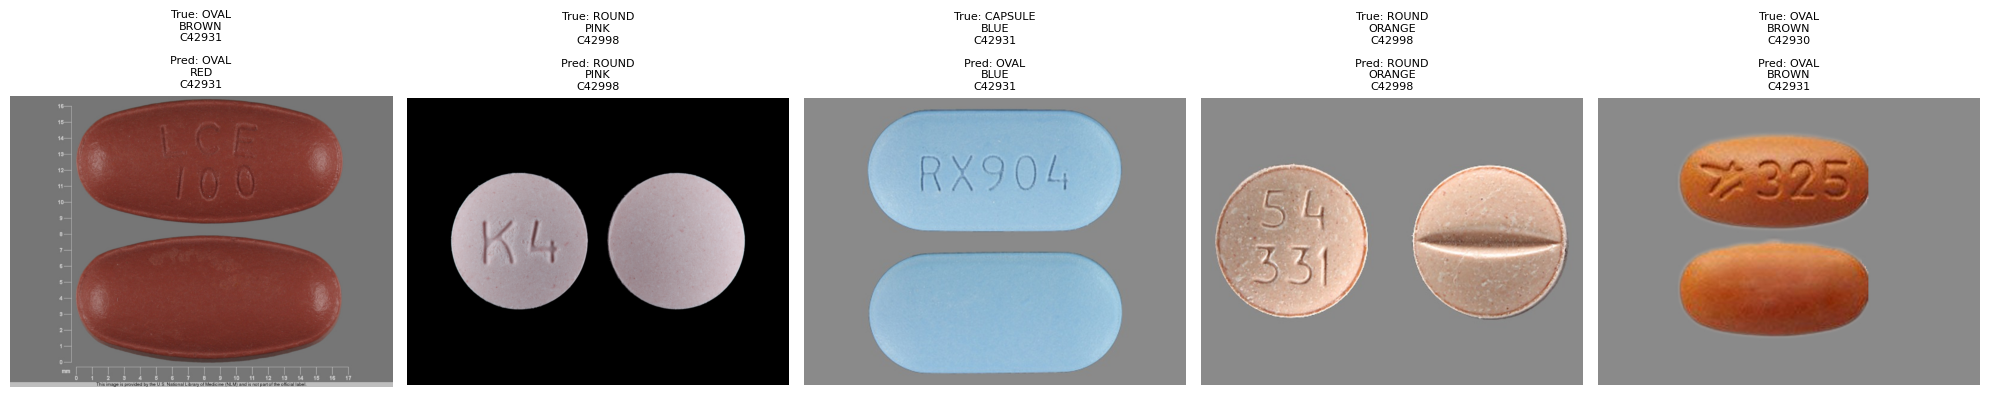

In [13]:
import matplotlib.pyplot as plt
import random

random.seed(42)
sample_indices = random.sample(range(len(test_df)), 5)
sample_data = test_df.iloc[sample_indices].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    img_path = sample_data.loc[idx, 'image_path']
    true_shape = sample_data.loc[idx, 'splshape_text']
    true_color = sample_data.loc[idx, 'splcolor_text']
    true_form = sample_data.loc[idx, 'dosage_form']
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        shape_out, color_out, form_out = loaded_model(img_tensor)
        pred_shape_idx = shape_out.argmax(dim=1).item()
        pred_color_idx = color_out.argmax(dim=1).item()
        pred_form_idx = form_out.argmax(dim=1).item()
    
    pred_shape = shape_encoder.inverse_transform([pred_shape_idx])[0]
    pred_color = color_encoder.inverse_transform([pred_color_idx])[0]
    pred_form = form_encoder.inverse_transform([pred_form_idx])[0]
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f"True: {true_shape}\n{true_color}\n{true_form}\n\n"
        f"Pred: {pred_shape}\n{pred_color}\n{pred_form}",
        fontsize=8
    )

plt.tight_layout()
plt.show()

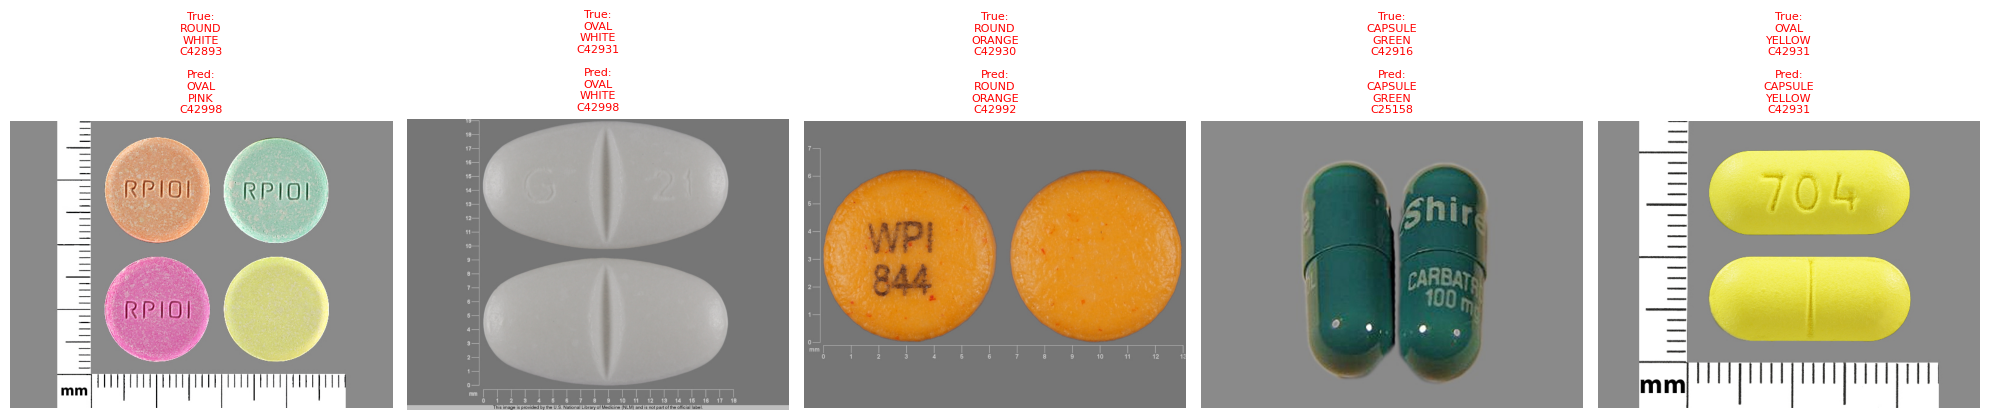

5 misclassified examples


In [14]:
misclassified = []

for idx in range(len(test_df)):
    row = test_df.iloc[idx]
    img_path = row['image_path']
    true_shape = row['splshape_text']
    true_color = row['splcolor_text']
    true_form = row['dosage_form']
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        shape_out, color_out, form_out = loaded_model(img_tensor)
        pred_shape_idx = shape_out.argmax(dim=1).item()
        pred_color_idx = color_out.argmax(dim=1).item()
        pred_form_idx = form_out.argmax(dim=1).item()
    
    pred_shape = shape_encoder.inverse_transform([pred_shape_idx])[0]
    pred_color = color_encoder.inverse_transform([pred_color_idx])[0]
    pred_form = form_encoder.inverse_transform([pred_form_idx])[0]
    
    if pred_shape != true_shape or pred_color != true_color or pred_form != true_form:
        misclassified.append({
            'img': img,
            'true_shape': true_shape,
            'true_color': true_color,
            'true_form': true_form,
            'pred_shape': pred_shape,
            'pred_color': pred_color,
            'pred_form': pred_form
        })
        if len(misclassified) == 5:
            break

if misclassified:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, example in enumerate(misclassified):
        axes[i].imshow(example['img'])
        axes[i].axis('off')
        axes[i].set_title(
            f"True:\n{example['true_shape']}\n{example['true_color']}\n{example['true_form']}\n\n"
            f"Pred:\n{example['pred_shape']}\n{example['pred_color']}\n{example['pred_form']}",
            fontsize=8,
            color='red'
        )
    plt.tight_layout()
    plt.show()
    print(f"{len(misclassified)} misclassified examples")
else:
    print("No misclassifications found!")